# Networks

##### Network using voltage based delta synapse

In [1]:
from brian2 import *

# Parameters
R            = 50  *Mohm          # membrane resitance [MOhm]
tauE_m        = 20.0 * ms          # excitatory neuron membrane time constant [ms]
tauI_m        = 10.0 * ms          # inhibitory neuron membrane time constant [ms]
cE_m          = tauE_m/R            # Capacitance excitatory neurons [nF]
cI_m          = tauI_m/R            # Capacitance excitatory neurons [nF]
tauRef       = 2.0 *ms            # refractory time [ms]
v_rest       = -70.0 *mV          # resting potential [mV]
Vt           = -50.0 *mV          # threshold [mV]
Vr           = -60.0 *mV          # reset [mV]  
tau_syn_e    = 0.1 *ms            # time constant for synapse [ms] (I'll tell more about it later)

# External input for assynchronous behavior
VextE         = 14.2 *mV           # External input in excitatory neurons
VextI         = 14.7 *mV           # External input in excitatory neurons

# Neuron model without alpha function for synapses
eqs = '''
    dv/dt = ((v_rest-v)+vext)/tau_m   + (i_inj/c_m) + (sigma*(1./tau_m)**0.5)*xi : volt (unless refractory)
    i_inj : ampere
    vext  : volt
    sigma : volt
    tau_m : second
    c_m   : farad 
    '''

# Neuron model with alpha function for synpases
eqs_alpha = '''
    dv/dt = (v_rest-v)/tau_m + (ie + i_inj)/c_m + ((sigma*(tau_m**0.5)*xi)/c_m) : volt (unless refractory)
    
    die/dt = (2.7182818284590451*ye-ie)/tau_syn_e : ampere
    dye/dt = -ye/tau_syn_e                        : ampere
    i_inj : ampere
    sigma : ampere
    tau_m : second
    c_m   : farad 
    '''


# Noise
sigmaV=3*mV

# Coefficient
coeffE=0.67957046
coeffI=2*coeffE

# Integration step
defaultclock.dt = 0.1*ms

# Synaptic weights
wEE = .01 *mV
wIE = .075 *mV
wEI = -.0375 *mV
wII = -.075 *mV

# Connection probability
plocal = 0.1

In [2]:

######################################## Delta Function ###########################################################
# Population of excitatory neurons
PE = NeuronGroup(1600, eqs, threshold='v>Vt', reset='v = Vr', refractory=2*ms, method='euler')

# parameters
PE.v = v_rest         
PE.tau_m = tauE_m     
PE.c_m = cE_m         
PE.i_inj=0.*nA        
PE.vext=VextE         
PE.sigma=sigmaV   

# Population of inhibitory neurons
PI = NeuronGroup(400, eqs, threshold='v>Vt', reset='v = Vr', refractory=2*ms, method='euler')

# parameters
PI.v = v_rest         
PI.tau_m = tauI_m     
PI.c_m = cI_m         
PI.i_inj=0.*nA        
PI.vext=VextI         
PI.sigma=sigmaV 


# Synapses
Cee = Synapses(PE, PE, on_pre='v += wEE')
Cie = Synapses(PE, PI, on_pre='v += wIE')
Cei = Synapses(PI, PE, on_pre='v += wEI')
Cii = Synapses(PI, PI, on_pre='v += wII')

Cee.connect(p = plocal) 
Cie.connect(p = plocal) 
Cei.connect(p = plocal) 
Cii.connect(p = plocal) 

# Monitors
monitorsE = SpikeMonitor(PE)
monitorsI = SpikeMonitor(PI)
rateE = PopulationRateMonitor(PE)
rateI = PopulationRateMonitor(PI)



In [3]:
##################################### Alpha Function #############################################################


# Population of excitatory neurons
PE_alpha = NeuronGroup(1600, eqs_alpha, threshold='v>Vt', reset='v = Vr', refractory=2*ms, method='euler')

# parameters
PE_alpha.v = v_rest         
PE_alpha.tau_m = tauE_m     
PE_alpha.c_m = cE_m         
PE_alpha.i_inj=(VextE/R)                 
PE_alpha.sigma=(sigmaV/R)   

# Population of excitatory neurons
PI_alpha = NeuronGroup(400, eqs_alpha, threshold='v>Vt', reset='v = Vr', refractory=2*ms, method='euler')

# parameters
PI_alpha.v = v_rest         
PI_alpha.tau_m = tauI_m     
PI_alpha.c_m = cI_m         
PI_alpha.i_inj=(VextI/R)           
PI_alpha.sigma=(sigmaV/R) 

# reset weigths for alpha synapse
wEE_alpha = ((wEE/mV)/coeffE)*nA
wIE_alpha = ((wIE/mV)/coeffI)*nA
wEI_alpha = ((wEI/mV)/coeffE)*nA
wII_alpha = ((wII/mV)/coeffI)*nA

# Synapses
Cee_alpha = Synapses(PE_alpha, PE_alpha, on_pre='ye += wEE_alpha')
Cie_alpha = Synapses(PE_alpha, PI_alpha, on_pre='ye += wIE_alpha')
Cei_alpha = Synapses(PI_alpha, PE_alpha, on_pre='ye += wEI_alpha')
Cii_alpha = Synapses(PI_alpha, PI_alpha, on_pre='ye += wII_alpha')

Cee_alpha.connect(p = plocal) 
Cie_alpha.connect(p = plocal) 
Cei_alpha.connect(p = plocal) 
Cii_alpha.connect(p = plocal) 

# Monitors
monitorsE_alpha = SpikeMonitor(PE_alpha)
monitorsI_alpha = SpikeMonitor(PI_alpha)
rateE_alpha = PopulationRateMonitor(PE_alpha)
rateI_alpha = PopulationRateMonitor(PI_alpha)

# Run simulation
run( 1* second)

INFO       width adjusted from 10. ms to 10.1 ms [brian2.monitors.ratemonitor.adjusted_width]


Text(0.5, 0, 'Time (seconds)')

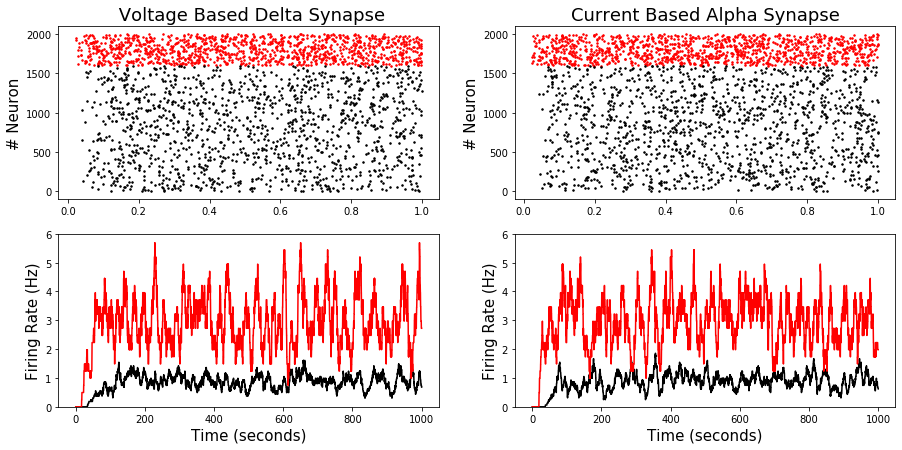

In [4]:
rcParams['figure.figsize'] = 15, 7
subplot(221)
plot(monitorsI.t/second,1600+monitorsI.i,'r.',markersize=3)
plot(monitorsE.t/second,monitorsE.i,'k.',markersize=3)
ylabel('# Neuron',fontsize=15)
title (' Voltage Based Delta Synapse',fontsize=18)


subplot(222)

plot(monitorsI_alpha.t/second,1600+monitorsI_alpha.i,'r.',markersize=3)
plot(monitorsE_alpha.t/second,monitorsE_alpha.i,'k.',markersize=3)
ylabel('# Neuron',fontsize=15)
title ('Current Based Alpha Synapse',fontsize=18)

subplot(223)
plot(rateE.t/ms, rateE.smooth_rate(window='flat', width=10*ms)/Hz,'k')
plot(rateI.t/ms, rateI.smooth_rate(window='flat', width=10*ms)/Hz,'r')

ylabel('Firing Rate (Hz)',fontsize=15)
xlabel('Time (seconds)',fontsize=15)
ylim([0,6])

subplot(224)
plot(rateE_alpha.t/ms, rateE_alpha.smooth_rate(window='flat', width=10*ms)/Hz,'k')
plot(rateI_alpha.t/ms, rateI_alpha.smooth_rate(window='flat', width=10*ms)/Hz,'r')
ylim([0,6])
ylabel('Firing Rate (Hz)',fontsize=15)
xlabel('Time (seconds)',fontsize=15)